In [1]:
# imports

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
# data load and division

data_dir = "/Users/anisshamdi/Desktop/DataScientest/Projet/COVID-19_Radiography_Dataset/Images"

batch_size = 128
img_height = 224
img_width = 224

# 80% training

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

# 20% validation

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

# perf configuration - improve loading perf (cache, shuffle and overlap between preprocess and training)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15153 files belonging to 3 classes.
Using 12123 files for training.
Found 15153 files belonging to 3 classes.
Using 3030 files for validation.


In [3]:
# the model: ResNet50

base_model = keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False
)

# Freeze pour ne pas s'embeter avec les weights du modele originel
base_model.trainable = False

# changer les dernières couches parce que 4 classes au lieu de 1000 dans le modele originel
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
# model training

epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


2024-03-15 15:43:39.686506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12123]
	 [[{{node Placeholder/_4}}]]
2024-03-15 15:43:39.687057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12123]
	 [[{{node Placeholder/_4}}]]
2024-03-15 15:43:40.542937: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


95/95 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.8189

2024-03-15 15:50:06.441372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3030]
	 [[{{node Placeholder/_4}}]]
2024-03-15 15:50:06.441718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3030]
	 [[{{node Placeholder/_4}}]]


95/95 [==============================] - 483s 5s/step - loss: 0.4675 - accuracy: 0.8189 - val_loss: 0.2707 - val_accuracy: 0.8937
Epoch 2/5
95/95 [==============================] - 2088s 22s/step - loss: 0.2446 - accuracy: 0.9115 - val_loss: 0.2352 - val_accuracy: 0.9165
Epoch 3/5
95/95 [==============================] - 506s 5s/step - loss: 0.1968 - accuracy: 0.9314 - val_loss: 0.1814 - val_accuracy: 0.9350
Epoch 4/5
95/95 [==============================] - 524s 6s/step - loss: 0.1712 - accuracy: 0.9391 - val_loss: 0.1668 - val_accuracy: 0.9419
Epoch 5/5
95/95 [==============================] - 532s 6s/step - loss: 0.1572 - accuracy: 0.9442 - val_loss: 0.1529 - val_accuracy: 0.9525


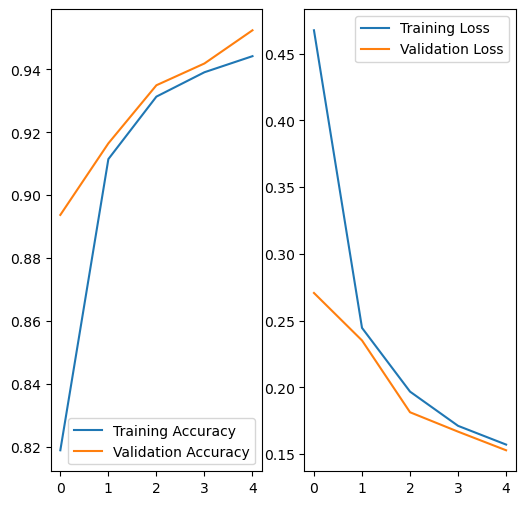

In [5]:
# results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show();


In [6]:
import pickle

model.save('resnet50_10.keras')

with open('resnet50_10_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
